聚类实现：
--
将数据聚类方法检测噪声（即不属于某类时判断为噪声）

--对噪声加权（大噪声剔除，小噪声加权减小噪声影响，权重与距离有关）

--距离选取：以每年的中心值为中心，计算欧式或

--GP处理，周期性核函数

--多信息--预测检测

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import pandas as pd
from matplotlib import gridspec
%matplotlib inline

import scipy as sp
from Plot_raw import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


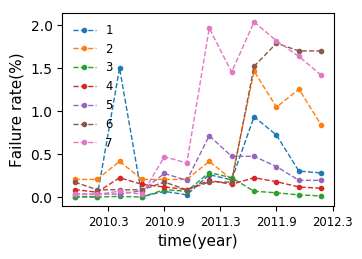

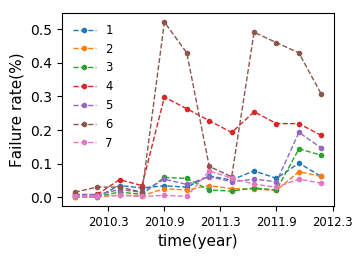

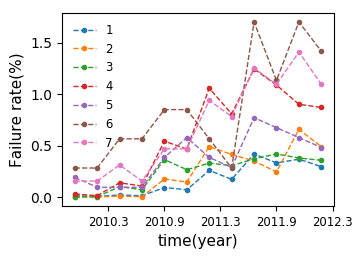

In [2]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
# elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
# elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year[:,None] #必须要这种形式才行

# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100*(elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults[2] = 1.5
# elec_faults[85] = 0.4
 
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])
# elec_faults2 = np.ma.masked_values(elec_faults2, value=1000)

Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置

ys_faultsA = shared(np.asarray(elec_faults[:84]))
# ys_faultsB = shared(np.asarray(elec_faults[84:168]))
# ys_faultsC = shared(np.asarray(elec_faults[168:]))

xs_yearA = shared(np.asarray(elec_year[:84]))
# xs_yearB = shared(np.asarray(elec_year[84:168]))
# xs_yearC = shared(np.asarray(elec_year[168:]))
# Num_shared = shared(np.asarray(companyABC))

In [32]:
y_fault = np.array([0 for i in np.arange(len(elec_year))])

# bbb = elec_year[:, None]
ccc = elec_tem[:, None]
ddd = elec_hPa[:, None]
eee = elec_RH[:, None]
hhh = elec_faults[:, None]

aaa = np.hstack((hhh, eee, ddd, ccc))
print(len(aaa))

y_fault = elec_faults
# print(len(ddd))
# ggg = sorted(y_fault)
# print(ggg)

252


DBSCAN：前两个省效果不错，但第三个省的数据比较特殊，效果不好，修改后可使用
--

In [4]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [33]:
# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X = hhh
X = aaa
labels_true = companyABC
# print(labels_true)
X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.7, min_samples=25).fit(X) #改这里eps的值，增大的话可以减少聚类对噪声的敏感度
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))



[ 0  1 -1  1  0  1  0  1 -1 -1  0  1  0  1  0  1  0  1  0  1 -1 -1 -1 -1
  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1  0  1
  0  1  0  1  0  1 -1  1  0  1  0  1  0  1  0  1  0  1  0  1 -1 -1 -1 -1
  0  1  0  1  0  1 -1 -1 -1 -1 -1 -1  3  2  3  2  3  2  3  2  3  2  3  2
  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2
  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2
  3  2  3  2 -1  2  3  2  3 -1  3  2  3  2  3  2  3  2  3  2  3  2  3  2
  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3 -1  3
  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3  4  3 -1 -1 -1 -1 -1 -1
  4  3  4  3  4  3  4  3 -1 -1 -1  3  4  3  4  3 -1 -1  4  3 -1 -1 -1 -1
  4  3  4  3  4  3 -1 -1 -1 -1 -1 -1]
Estimated number of clusters: 5
Homogeneity: 0.691
Completeness: 0.436
V-measure: 0.535


D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return comb(n, 2, exact=1)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return comb(n, 2, exact=1)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return comb(n, 2, exact=1)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `sc

Adjusted Rand Index: 0.337
Adjusted Mutual Information: 0.430
Silhouette Coefficient: 0.483


K-mean:有缺陷,只能强行分到某一类，效果不好，不推荐
--

In [21]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

[3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3
 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0 3 0
 3 0 3 0 3 0 3 0 3 0 1 4 1 4 1 6 1 4 1 6 1 6 1 4 1 4 1 6 1 4 1 6 1 6 1 4 1
 4 1 6 1 4 1 6 1 6 1 4 1 4 1 6 1 4 1 6 1 6 1 4 1 4 1 6 1 4 1 6 1 6 1 4 1 4
 1 6 1 4 1 6 1 6 1 4 1 4 1 6 1 4 1 6 1 6 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2
 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5
 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5 2 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

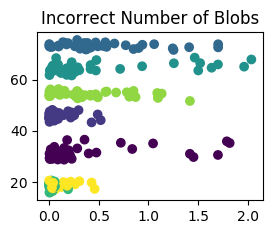

In [26]:
random_state = 10
X1 = aaa
labels_true = companyABC
# Incorrect number of clusters
kmeans = KMeans(n_clusters=7, random_state=random_state).fit(X1)
labels0 = kmeans.labels_
print(labels0)
print(companyABC)

plt.subplot(221)
plt.scatter(X1[:, 0], X1[:, 1], c=labels0)
plt.title("Incorrect Number of Blobs")

plt.show()

AffinityPropagation：效果和第一种DBSCAN差不多，但是会将第二个省数据分错，不推荐
--

In [27]:
from sklearn.cluster import AffinityPropagation

In [28]:
# Compute Affinity Propagation
af = AffinityPropagation(preference=-30).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels2 = af.labels_
print(labels2)
print(companyABC)
n_clusters_ = len(cluster_centers_indices)

labels_true = companyABC
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels2))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels2))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels2))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels2))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels2))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels2, metric='sqeuclidean'))

[1 0 2 0 1 0 1 0 2 0 1 0 1 0 1 0 1 0 1 0 2 0 2 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 2 2 2 2 1 0
 1 0 1 0 2 2 2 2 2 2 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3
 4 3 4 3 6 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5
 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 5 6 7 6 7 7 7 6 5 6 5 6 5 6
 5 6 5 6 5 6 5 6 5 6 7 6 5 6 7 7 7 7 5 6 5 6 5 6 7 6 7 7 7 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return comb(n, 2, exact=1)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return comb(n, 2, exact=1)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return comb(n, 2, exact=1)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:32: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `sc

Adjusted Rand Index: 0.476
Adjusted Mutual Information: 0.530
Silhouette Coefficient: 0.748


Spectral clustering:输入必须是2维，不考虑
--

In [29]:
from sklearn.cluster import spectral_clustering

Birch:不好
--

In [30]:
from sklearn.cluster import Birch

In [31]:
 X4 = aaa
brc = Birch(threshold=2.7, branching_factor=60, n_clusters=None,compute_labels=True)
brc.fit(X4)
label4 = brc.labels_
# brc.predict(X4)
print(label4)
print(companyABC)

[ 0  1  0  1  0  1  0  1  2  1  0  1  0  1  0  1  0  1  0  1  2  1  2  1
  0  1  0  1  0  1  0  1  2  1  0  1  0  1  0  1  0  1  0  1  2  1  0  1
  0  1  0  1  0  1  0  1  2  1  0  1  0  1  0  1  0  1  0  1  2  1  2  1
  0  1  0  1  0  1  2  1  2  1  0  1  3  4  5  4  6  7  3  4  3  7  5  7
  3  4  5  4  6  7  3  4  3  7  5  7  3  4  5  4  6  7  3  4  3  7  5  7
  3  4  5  4  6  7  3  4  3  7  5  7  3  4  5  4  6  7  3  4  3  7  5  7
  3  4  5  4  6  7  3  4  3  7  5  7  3  4  5  4  6  7  3  4  3  7  5  7
  8  9  8  9  8  9  8  9  8  9 10  9  8  9  8  9  8  9  8  9  8  9 10  9
  8  9  8  9  8  9  8  9  8  9 10  9  8  9  8  9  8  9  8  9  8  9 10  9
  8  9  8  9  8  9  8  9  8  9 10  9  8  9  8  9  8  9  8  9  8  9 10  9
  8  9  8  9  8  9  8  9  8  9 10  9]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 